In [1]:
!pip --version

pip 21.2.3 from /Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/pip (python 3.9)


In [ ]:
!pip install numpy scikit-learn networkx matplotlib

In [23]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
def load_numpy_2d_array_from_file(filepath):
    """Load a numpy 2d array from a file"""
    array = np.loadtxt(filepath, delimiter=" ")
    return array

embedding = load_numpy_2d_array_from_file("/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/data/facebook_combined_embedding.txt")

In [19]:
embedding.shape

(4039, 100)

/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_38019/1993839515.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap="tab10")


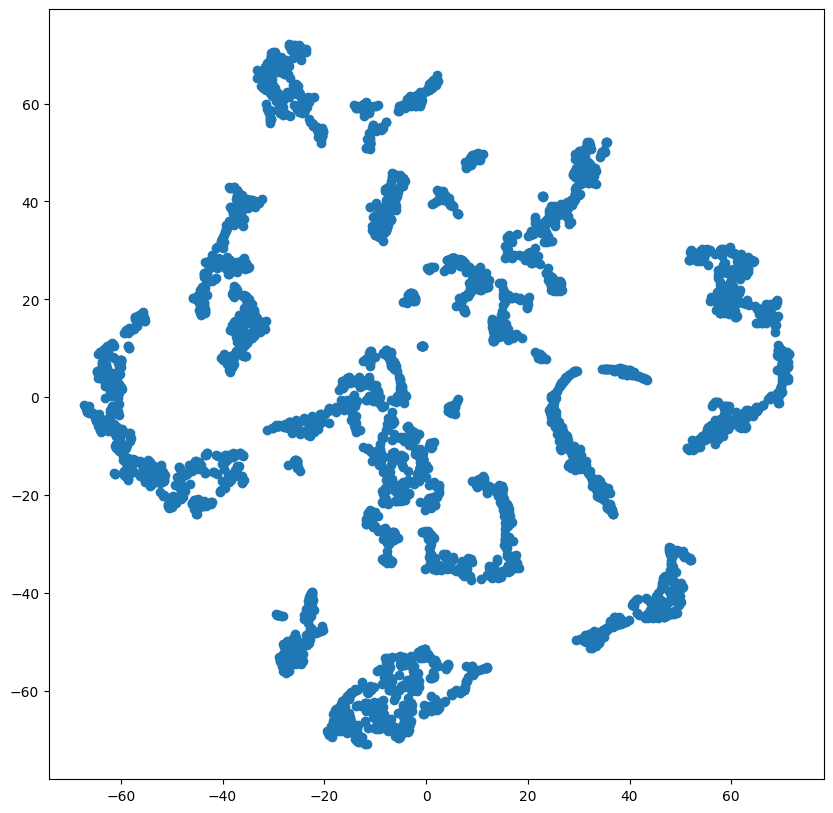

In [24]:
# First we reduce the dimensionality of the embedding using PCA
embedding_pca = PCA(n_components=2).fit_transform(embedding)

# Then we use t-SNE to visualize the embedding
tsne = TSNE(n_components=2, random_state=0)
embedding_2d = tsne.fit_transform(embedding_pca)

def plot_embedding(embedding_2d):
    """Plot the embedding"""
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap="tab10")
    plt.show()

plot_embedding(embedding_2d)